In [1]:
# In[2]:


import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))


# In[3]:


from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


# In[4]:


print("Map properties")

# number of pixels for the flat map
nX = 800
nY = 800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra


# In[5]:


print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


# In[6]:


print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)


# In[7]:


print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 


# In[9]:


#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
#def rgb2gray(rgb):
#    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
#
#from scipy.ndimage import gaussian_filter 
#from scipy.fft import fft2
#
#mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
#apodized_mask = gaussian_filter(mask, 3)
#point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
#point_sources = gaussian_filter(point_sources, 1.5) 
#apodized_mask += point_sources
#nPos = np.where(apodized_mask>1)
#apodized_mask[nPos] = 1
#mask = 1-mask
#apodized_mask = 1 - apodized_mask
#
#for a in apodized_mask:
#    for b in a:
#        assert(b<=1 and b>=0)
## plt.imshow(apodized_mask)


Map properties
CMB experiment properties
CMB lensing power spectrum
Gets a theoretical prediction for the noise
computing the reconstruction noise


/home/users/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/home/users/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [33]:
def apply_cos(fourierData):
    realData = baseMap.inverseFourier(fourierData)
    f = lambda x: -60*np.cos(np.pi*x/2000)+61
    frow = np.array(list(map(f, range(len(realData[0])))))
    realData = realData * frow
    return baseMap.fourier(realData)

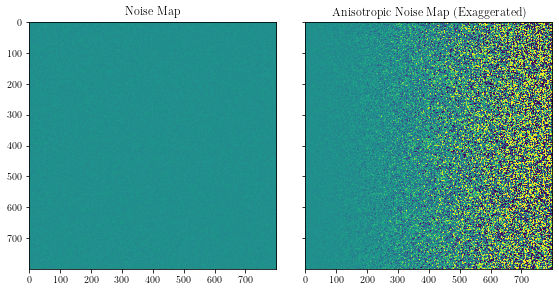

In [34]:
fig, axs = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.tight_layout() 
noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
noiseReal = baseMap.inverseFourier(noiseFourier)
axs[0].imshow(noiseReal, vmin=-40, vmax=40)
axs[0].set_title('Noise Map')
noiseFourier = apply_cos(noiseFourier)
noiseReal = baseMap.inverseFourier(noiseFourier)
axs[1].imshow(noiseReal, vmin=-40, vmax=40)
axs[1].set_title('Anisotropic Noise Map (Exaggerated)')
plt.savefig('figures/anisotropic_noise_map_exaggeratd_visual.pdf', bbox_inches = 'tight')